In [2]:
import numpy as np
from datetime import timedelta
import os, sys
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

notebook_path = os.getcwd()
print(notebook_path)
sys.path.append(os.path.join(notebook_path, '..', '..'))
from studies.flair import Flair

/Users/jan/git/nudgebg/egvinsulin/notebooks/understand-flair-dataset


# TDD

In [3]:
study_dataset_path = os.path.join(notebook_path, '..','..', 'data', 'raw', 'FLAIRPublicDataSet')
flair = Flair('Flair', study_dataset_path)
flair.load_data();

In [4]:
basal = flair.extract_basal_event_history()
bolus = flair.extract_bolus_event_history()

Now we calculate TDD, once based on the extracted basal and bolus information (calculated) and once on the reported TDD of the flair data (reported)

In [8]:
def calculate_tdd_basals(df):
    #add support points around midnight 
    supports = pd.date_range(df.datetime.min().date(), df.datetime.max().date()+pd.Timedelta(days=1), freq='D')
    missing_supports = supports[~supports.isin(df.datetime)]
    
    df = pd.concat([df, pd.DataFrame({'datetime': missing_supports})]).sort_values(by='datetime').reset_index(drop=True)
    df['basal_rate'] = df.basal_rate.ffill()
    #calculate TDDs, one day at a time
    TDDs  = []
    for (start,end) in zip(supports[:-1], supports[1:]):
        subFrame = df.loc[(df.datetime >= start) & (df.datetime <= end)]
        x = (subFrame.datetime.diff().dt.total_seconds()/3600).values[1:]
        y = subFrame['basal_rate'].values[:-1]
        tdd = np.nansum(x * y)
        TDDs.append(tdd)
    return pd.DataFrame({'date': supports[:-1].date, 'basal': TDDs})

from datetime import datetime
#test 1
test = pd.DataFrame({'datetime':[datetime(2019,1,1),datetime(2019,1,1,12)], 'basal_rate':[0,1.5]})
expected = pd.DataFrame({'date':[datetime(2019,1,1).date()], 'basal':[18.0]})
calculated_tdd = calculate_tdd_basals(test)
assert np.all(calculated_tdd['basal'].values == expected['basal'].values)

#test 2
test = pd.DataFrame({'datetime':[datetime(2019,1,1),datetime(2019,1,1,6),datetime(2019,1,1,12)], 'basal_rate':[0,1,2]})
expected = pd.DataFrame({'date':[datetime(2019,1,1).date()], 'basal':[30.0]})
calculated_tdd = calculate_tdd_basals(test)
assert np.all(calculated_tdd['basal'].values == expected['basal'].values)

#test 2
test = pd.DataFrame({'datetime':[datetime(2019,1,1,12)], 'basal_rate':[1]})
expected = pd.DataFrame({'date':[datetime(2019,1,1).date()], 'basal':[12.0]})
calculated_tdd = calculate_tdd_basals(test)
assert np.all(calculated_tdd['basal'].values == expected['basal'].values)


In [246]:
def extract_TDDs():
    tdds_flair = flair.df_pump.dropna(subset=['TDD'])[['PtID','DateTime','TDD']]
    tdds_flair['date'] = tdds_flair.DateTime.dt.date
    tdds_flair['datetime'] = tdds_flair.DateTime
    tdds_flair['PtID'] = tdds_flair.PtID.astype(str)
    tdds_flair = tdds_flair.rename(columns={'PtID':'patient_id','TDD':'tdd'})
    return tdds_flair

#calculate basal tdd
tdd_basals = pd.DataFrame(basal.groupby(basal.patient_id).apply(calculate_tdd_basals))
tdd_basals = tdd_basals.reset_index().set_index(['patient_id','date']).drop(columns='level_1')
#display(tdd_basals.head())

#calcualte bolus tdd
date = bolus.datetime.dt.date
date.name='date'
tdd_boluses = bolus.groupby(['patient_id',date]).agg({'bolus':'sum'})
#display(tdd_boluses.head())

#combine bolus and basal tdds
tdds_calculated = pd.merge(tdd_boluses ,tdd_basals, left_index=True, right_index=True, suffixes=['_bolus','_basal'])
tdds_calculated['tdd'] = tdds_calculated.bolus + tdds_calculated.basal

#get reported tdd 
tdd_reported = extract_TDDs().set_index(['patient_id','date'])
tdd_reported.name = 'reported'

#combine dataframes and scatter plot
TDDs = pd.merge(tdds_calculated, tdd_reported, left_index=True, right_index=True, suffixes=['_calculated','_reported'])
display(TDDs)

bolus      basal  tdd_calculated            DateTime  \
patient_id date                                                               
1          2018-08-08  16.50  12.365611       28.865611 2018-08-08 23:59:59   
           2018-08-09  26.00  24.870528       50.870528 2018-08-09 23:59:59   
           2018-08-10  16.10  30.171111       46.271111 2018-08-10 23:59:59   
           2018-08-11  17.80  24.464417       42.264417 2018-08-11 23:59:59   
           2018-08-12  28.50  25.651111       54.151111 2018-08-12 23:59:59   
...                      ...        ...             ...                 ...   
99         2019-02-28  43.97  32.990611       76.960611 2019-02-28 23:59:59   
           2019-03-01  44.28  32.440722       76.720722 2019-03-01 23:59:59   
           2019-03-02  53.91  31.958111       85.868111 2019-03-02 23:59:59   
           2019-03-03  44.47  32.752222       77.222222 2019-03-03 23:59:59   
           2019-03-04  47.74  33.114667       80.854667 2019-03-04 23:59:59   

                       tdd_reported            datetime  
patient_id date                                          
1          2018-08-08        28.875 2018-08-08 23:59:59  
           2018-08-09        50.825 2018-08-09 23:59:59  
           2018-08-10        46.250 2018-08-10 23:59:59  
           2018-08-11        42.300 2018-08-11 23:59:59  
           2018-08-12        54.100 2018-08-12 23:59:59  
...                             ...                 ...  
99         2019-02-28        43.125 2019-02-28 23:59:59  
           2019-03-01        43.575 2019-03-01 23:59:59  
           2019-03-02        53.150 2019-03-02 23:59:59  
           2019-03-03        44.500 2019-03-03 23:59:59  
           2019-03-04        50.350 2019-03-04 23:59:59  

[25252 rows x 6 columns]

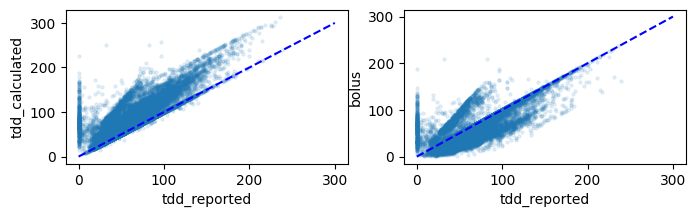

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
TDDs.plot.scatter(x='tdd_reported', y='tdd_calculated', marker='.', alpha=0.1, ax=axs[0])
axs[0].plot([0, 300], [0, 300], 'b--')
TDDs.plot.scatter(x='tdd_reported', y='bolus', marker='.', alpha=0.1, ax=axs[1])
axs[1].plot([0, 300], [0, 300], 'b--')

What we see is that the 
* calcualted tdds differ significantly from the extracted tdds 
* mostly calculated TDDs are too hight

There are multiple clusters:
 * Many instances where the extracted TDD is zero
 * Many instances where the calcualted is higher what appears to be a linear offset
* When looking at the boluses only, some TDDs are still too high.

Potential explanation for this: Potentiually the algorithm was switched and reported basal-rates were not actually delivered. Therefore, let's visualize reported basal rates by date.

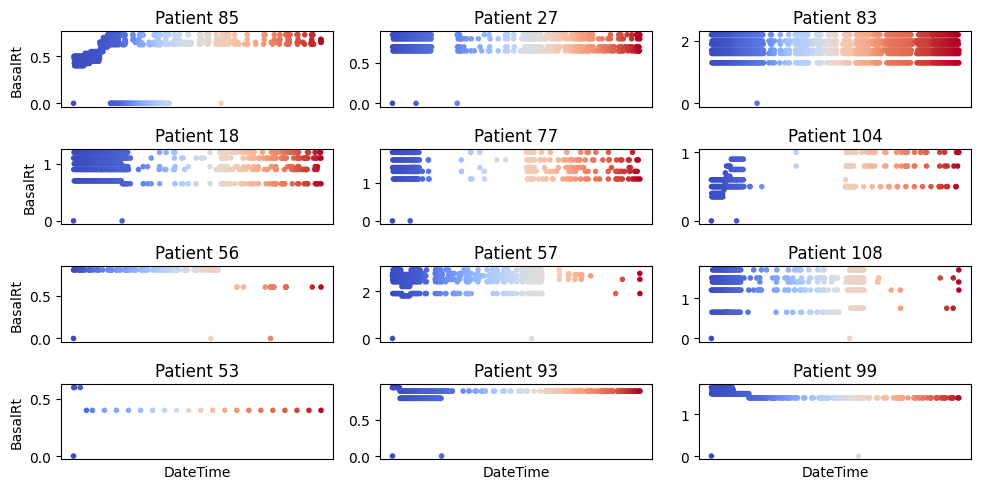

In [11]:
patient_ids = [85,27,83,   18,77,104,  56,57,108,  53,93,99]
#patient_ids = np.random.choice(np.unique(flair.df_pump.PtID.unique()),8, replace=False)
fig, axs = plt.subplots(4,3, figsize=(10, 5)); axs = axs.flatten()
for i, patient_id in enumerate(patient_ids):
    subFrame = flair.df_pump.loc[flair.df_pump.PtID == patient_id]#.dropna(subset=['BasalRt'])
    axs[i].scatter(subFrame['DateTime'], subFrame['BasalRt'], c=range(len(subFrame)), cmap='coolwarm', marker='.')
    axs[i].set_title(f'Patient {patient_id}')
    #hide x ticks
    axs[i].set_xticks([])
    if i>=9:
        axs[i].set_xlabel('DateTime')
    if i%3==0:
        axs[i].set_ylabel('BasalRt')

plt.tight_layout()
plt.show()

1. First row: basal rates regularly change start to end
2. Second Row: basal rates changebut in the middle they are not reported or very infrequently
3. Third Row: Basal rates are first reported regularly, then stop or very rarely
4. Forth Row: Basal rates remain constant 

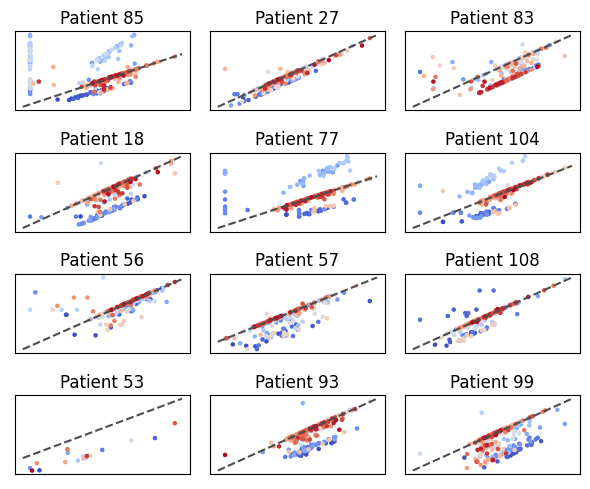

In [12]:
#scatter plot tdd_calcualted vs tdd_extracted for this patient
patient_ids = [85,27,83,   18,77,104,  56,57,108,  53,93,99]

fig, axs = plt.subplots(4, 3, figsize=(6, 5)); axs = axs.flatten()
for i, patient_id in enumerate(patient_ids):
    TDDs.loc[str(patient_id)].plot.scatter(x='tdd_reported', y='bolus', c=range(len(TDDs.loc[str(patient_id)])), cmap='coolwarm', marker='.', ax=axs[i])
    axs[i].set_title(f'Patient {patient_id}')
    #unity line
    axs[i].plot(axs[i].get_xlim(), axs[i].get_xlim(), ls="--", c=".3")
    #hide x and y ticks
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].set_xlabel(''); axs[i].set_ylabel('')
plt.tight_layout()
plt.show()

In order to understand what is really happening, we need to look at the study protocol and individuals. Let's start with patient 99 for which we know the bolus alsmost exactly matches TDD:


## Investigate Patient 99 more closely

We now investigate patient 99:

bolus             43.970000
basal             32.990611
tdd_calculated    76.960611
tdd_reported      43.125000
Name: 2019-02-28, dtype: float64

Text(0.5, 0.98, 'Patient 99')

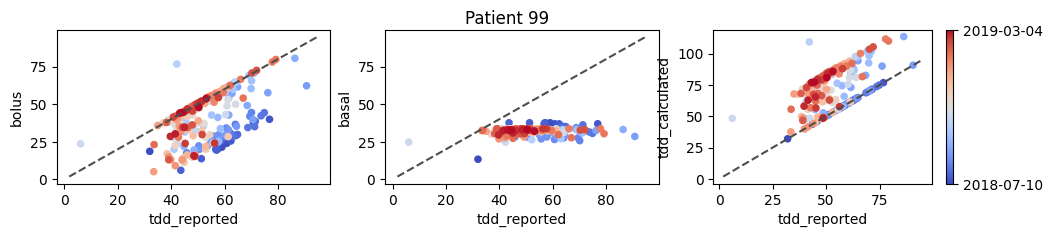

In [13]:
f, AX = plt.subplots(1,3, figsize=(12, 2))
display(TDDs.loc['99'].iloc[-5])
#scatter plot tdd_calcualted vs tdd_extracted for this patient
TDDs.loc['99'].sort_index().plot.scatter(x='tdd_reported', y='bolus', c=range(len(TDDs.loc['99'])), cmap='coolwarm', marker='o', ax = AX[0])
TDDs.loc['99'].sort_index().plot.scatter(x='tdd_reported', y='basal', c=range(len(TDDs.loc['99'])), cmap='coolwarm', marker='o', ax = AX[1])
TDDs.loc['99'].sort_index().plot.scatter(x='tdd_reported', y='tdd_calculated', c=range(len(TDDs.loc['99'])), cmap='coolwarm', marker='o', ax = AX[2])

#add unity line with limits to the limits of the current axis
AX[0].plot(AX[0].get_xlim(), AX[0].get_xlim(), ls="--", c=".3")
AX[1].plot(AX[1].get_xlim(), AX[1].get_xlim(), ls="--", c=".3")
AX[2].plot(AX[2].get_xlim(), AX[2].get_xlim(), ls="--", c=".3")
#add a heatmap of the colors that we used for scatter plotting
# Add a heatmap of the colors that we used for scatter plotting
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0, vmax=len(TDDs.loc['99'])))
cbar = plt.colorbar(sm)
cbar.set_ticks([0, len(TDDs.loc['99'])])  # Set ticks to start and end
cbar.set_ticklabels([TDDs.loc['99'].index.min(), TDDs.loc['99'].index.max()])  # Set tick labels to start and end dates
#title patient id
f.suptitle('Patient 99')

In [14]:
from datetime import datetime
#patient 99 date 2019-02-28
date = datetime(2019,2,28).date()
patient = 99
print(f"TDD for patient {patient} is {TDDs.tdd_reported.loc[str(patient),date].values[0]}")

#get the raw data subframe for that day
df = flair.df_pump.loc[(flair.df_pump.PtID==patient) & (flair.df_pump.DateTime.dt.date == date)]
print(f"Bolus delivered sum is {df.BolusDeliv.sum()}")

subBasals = basal.loc[(basal.patient_id == str(patient)) & (basal.datetime.dt.date == date)]
print(f"There are {len(df.dropna(subset=['BasalRt']))} basal events in the original dataframe but {len(subBasals)} in the extracted basal dataframe")
display(subBasals)

TDD for patient 99 is 43.125
Bolus delivered sum is 43.97
There are 0 basal events in the original dataframe but 2 in the extracted basal dataframe


,patient_id,datetime,basal_rate
2520575,99,2019-02-28 05:49:32,0.0
2520574,99,2019-02-28 06:15:39,1.4


As we can see, for this day there are no basals! So we must have an error in the basal forward filling. 

The original dataframe has no data but the extracted does. We see that the index 2520574 is in fact a suspend event. We probably used this to forward propagate the basal rate of the previous day. We see that no basal rates were reported after the 27th and we forward filled this for the suspends. This might have been wrong. It looks like this is the end of the dataframe.

In [15]:
# show row 2520574
flair.df_pump.loc[2520574]

PtID                                     99
DataDtTm               2/28/2019 6:15:39 AM
NewDeviceDtTm                           NaN
BasalRt                                 NaN
BasalRtUnKnown                        False
TempBasalAmt                            NaN
TempBasalType                           NaN
TempBasalDur                            NaN
BolusType                               NaN
BolusSelected                           NaN
BolusDeliv                              NaN
ExtendBolusDuration                     NaN
PrimeVolumeDeliv                        NaN
Suspend                      NORMAL_PUMPING
Rewind                                  NaN
BolusSource                             NaN
TDD                                     NaN
DateTime                2019-02-28 06:15:39
Name: 2520574, dtype: object

## Review Study Procotol
First, we check if auto-boluses are reported several times by checking a single patient.

In [16]:
display(flair.df_pump.BolusSource.unique())
#select patient 99
df = flair.df_pump.loc[flair.df_pump.PtID==1]
sample = df.loc[df.BolusSource=='CLOSED_LOOP_AUTO_BOLUS'].sample()
sample_time = sample.DateTime.values[0]
df = df.loc[(df.DateTime > sample_time-pd.Timedelta(hours=0.5)) & (df.DateTime<sample_time +pd.Timedelta(hours=0.5))]
#select previous 5 and post 5 events around event
df.dropna(subset=['BolusDeliv']).sort_values('DateTime').head(10)[['DateTime','BolusDeliv','BolusSource']]

array([nan, 'BOLUS_WIZARD', 'MANUAL', 'CL_MICRO_BOLUS',
       'CLOSED_LOOP_AUTO_BOLUS', 'CL_BG_CORRECTION_N_FOOD_BOLUS',
       'CL_BG_CORRECTION', 'CL_FOOD_BOLUS', 'CLOSED_LOOP_MICRO_BOLUS',
       'CLOSED_LOOP_FOOD_BOLUS',
       'CLOSED_LOOP_BG_CORRECTION_AND_FOOD_BOLUS',
       'CLOSED_LOOP_BG_CORRECTION'], dtype=object)

,DateTime,BolusDeliv,BolusSource
2179884,2018-11-03 08:04:45,0.10,CLOSED_LOOP_MICRO_BOLUS
2179883,2018-11-03 08:10:00,0.08,CLOSED_LOOP_MICRO_BOLUS
2179877,2018-11-03 08:15:18,0.80,CLOSED_LOOP_AUTO_BOLUS
2179876,2018-11-03 08:19:50,0.15,CLOSED_LOOP_MICRO_BOLUS
2179875,2018-11-03 08:24:50,0.13,CLOSED_LOOP_MICRO_BOLUS
2179873,2018-11-03 08:29:54,0.30,CLOSED_LOOP_AUTO_BOLUS
2179872,2018-11-03 08:35:02,0.13,CLOSED_LOOP_MICRO_BOLUS
2179871,2018-11-03 08:40:02,0.15,CLOSED_LOOP_MICRO_BOLUS
2179870,2018-11-03 08:45:00,0.13,CLOSED_LOOP_MICRO_BOLUS
2179869,2018-11-03 08:49:58,0.15,CLOSED_LOOP_MICRO_BOLUS


Let's start investigating a day where reported TDD is zero. Are we making a mistake? How do we come up with anything higher?

In [19]:
#query reported TDDs == 0
TDDs_sorted.loc[TDDs_sorted.tdd_reported == 0]
#let's look at the first row (patient 14, date 2019-09-17)
tmp = flair.df_pump.loc[(flair.df_pump.PtID==14) & (flair.df_pump.DateTime.dt.date == datetime(2019,9,17).date())]
tmp.dropna(subset=['BolusDeliv','BasalRt'],how='all').sort_values('DateTime').head(10)[['PtID','DateTime','BolusDeliv','BolusSource','BasalRt']]

,PtID,DateTime,BolusDeliv,BolusSource,BasalRt
2422868,14,2019-09-17 00:00:00,NaN,NaN,1.55
2443131,14,2019-09-17 00:04:52,0.180,CLOSED_LOOP_MICRO_BOLUS,NaN
156388,14,2019-09-17 00:04:52,0.175,CL_MICRO_BOLUS,NaN
2443130,14,2019-09-17 00:09:44,0.050,CLOSED_LOOP_MICRO_BOLUS,NaN
156387,14,2019-09-17 00:09:44,0.050,CL_MICRO_BOLUS,NaN
156386,14,2019-09-17 00:14:42,0.050,CL_MICRO_BOLUS,NaN
2443129,14,2019-09-17 00:14:42,0.050,CLOSED_LOOP_MICRO_BOLUS,NaN
156385,14,2019-09-17 00:19:52,0.275,CL_MICRO_BOLUS,NaN
2443128,14,2019-09-17 00:19:52,0.280,CLOSED_LOOP_MICRO_BOLUS,NaN
156384,14,2019-09-17 00:24:50,0.275,CL_MICRO_BOLUS,NaN


As a surprise finding, we see that the CLOSED_LOOP+MICRO_BOLUS and CL_MICRO_BOLUS are duplicated for this patient.  Let's how often we have duplicates.

## Bolus Duplicates

In [20]:
flair.df_pump.BolusSource.value_counts()

CLOSED_LOOP_MICRO_BOLUS                     2628112
CL_MICRO_BOLUS                               542076
CLOSED_LOOP_AUTO_BOLUS                       490478
BOLUS_WIZARD                                  96003
CLOSED_LOOP_BG_CORRECTION_AND_FOOD_BOLUS      84708
CLOSED_LOOP_FOOD_BOLUS                        46554
CL_BG_CORRECTION_N_FOOD_BOLUS                 17901
CLOSED_LOOP_BG_CORRECTION                     15482
CL_FOOD_BOLUS                                 11734
MANUAL                                         4240
CL_BG_CORRECTION                               3158
Name: BolusSource, dtype: int64


The number of events is not equal. So we don't have a duplicate for every entry. 
Let's continue checking how often we have duplicates:

In [126]:
temp = flair.df_pump.dropna(subset=['BolusDeliv'])
temp = temp[temp.BolusSource.isin(['CL_MICRO_BOLUS', 'CLOSED_LOOP_MICRO_BOLUS'])]

duplicates = temp.duplicated(subset=['PtID','DateTime', 'BolusDeliv'], keep=False)
print(f"Number of duplicated micro boluses rows {duplicates.sum()} in percent these are {100*duplicates.sum()/len(temp):.1f}% of all micro boluses")

#show the first 4 duplicated rows
temp[duplicates].dropna(subset=['BolusDeliv','BasalRt'],how='all').sort_values('DateTime').head(4)[['PtID','DateTime','BolusDeliv','BolusSource','BasalRt']]

Number of duplicated micro boluses rows 145958 in percent these are 4.6% of all micro boluses


,PtID,DateTime,BolusDeliv,BolusSource,BasalRt
1223509,20,2018-08-23 18:15:44,0.1,CLOSED_LOOP_MICRO_BOLUS,NaN
101098,20,2018-08-23 18:15:44,0.1,CL_MICRO_BOLUS,NaN
101089,20,2018-08-23 18:35:44,0.1,CL_MICRO_BOLUS,NaN
1223504,20,2018-08-23 18:35:44,0.1,CLOSED_LOOP_MICRO_BOLUS,NaN


In [127]:
temp = flair.df_pump.dropna(subset=['BolusDeliv'])
duplicates = temp.duplicated(subset=['PtID', 'DateTime', 'BolusDeliv'], keep=False)
print(f"Overall, we have {duplicates.sum()} duplicated rows which makes {duplicates.sum()/len(temp)*100:.2f}% of all boluses")
#show the first 4 duplicated rows
temp[duplicates].dropna(subset=['BolusDeliv','BasalRt'],how='all').sort_values('DateTime').head(4)[['PtID','DateTime','BolusDeliv','BolusSource','BasalRt']]

Overall, we have 156176 duplicated rows which makes 4.39% of all boluses


,PtID,DateTime,BolusDeliv,BolusSource,BasalRt
104176,20,2018-07-11 19:18:00,2.3,NaN,NaN
1223945,20,2018-07-11 19:18:00,2.3,BOLUS_WIZARD,NaN
103116,20,2018-07-28 12:33:01,6.3,NaN,NaN
1223845,20,2018-07-28 12:33:01,6.3,BOLUS_WIZARD,NaN


## TDD without bolus duplicates

In [91]:
bolus_wo_dups = bolus[~bolus.duplicated(subset=['patient_id','datetime', 'bolus'], keep='first')]

#calcualte bolus tdd
date = bolus_wo_dups.datetime.dt.date
date.name='date'
tdd_boluses_wo_dups = bolus_wo_dups.groupby(['patient_id',date]).agg({'bolus':'sum'})
TDDs = TDDs.join(tdd_boluses_wo_dups, rsuffix='_wo_dups')

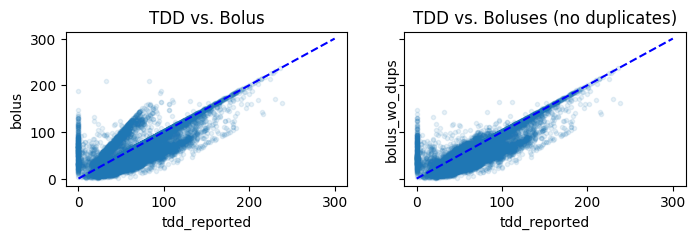

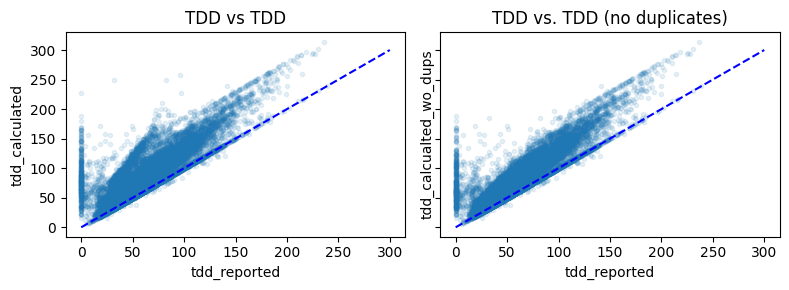

In [137]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2),sharex=True, sharey=True)
axs = axs.flatten()

axs[0].scatter(TDDs.tdd_reported, TDDs.bolus, marker='.', alpha=0.1)
axs[0].set_xlabel('tdd_reported')
axs[0].set_ylabel('bolus')
axs[0].set_title('TDD vs. Bolus')
axs[0].plot([0, 300], [0, 300], 'b--')

axs[1].scatter(TDDs.tdd_reported, TDDs.bolus_wo_dups, marker='.', alpha=0.1)
axs[1].set_xlabel('tdd_reported')
axs[1].set_ylabel('bolus_wo_dups')
axs[1].set_title('TDD vs. Boluses (no duplicates)')
axs[1].plot([0, 300], [0, 300], 'b--')

fig, axs = plt.subplots(1, 2, figsize=(8, 3),sharex=True, sharey=True)
axs = axs.flatten()

axs[0].scatter(TDDs.tdd_reported, TDDs.bolus+TDDs.basal, marker='.', alpha=0.1)
axs[0].set_xlabel('tdd_reported')
axs[0].set_ylabel('tdd_calculated')
axs[0].set_title('TDD vs TDD')
axs[0].plot([0, 300], [0, 300], 'b--')

axs[1].scatter(TDDs.tdd_reported, TDDs.bolus_wo_dups+TDDs.basal, marker='.', alpha=0.1)
axs[1].set_xlabel('tdd_reported')
axs[1].set_ylabel('tdd_calcualted_wo_dups')
axs[1].set_title('TDD vs. TDD (no duplicates)')
axs[1].plot([0, 300], [0, 300], 'b--')
plt.tight_layout()
plt.show()

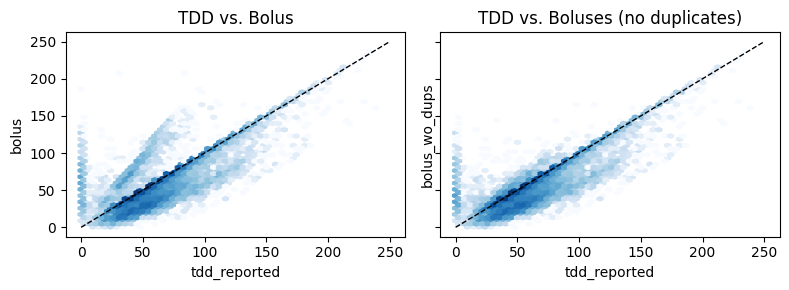

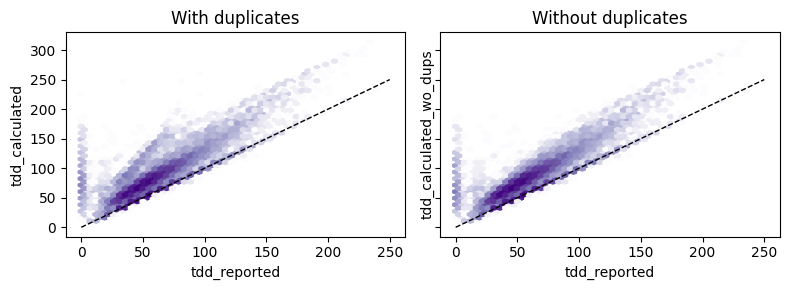

In [146]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

# Hexbin plot for TDD vs. Bolus with logarithmic color scale
hb1 = axs[0].hexbin(TDDs.tdd_reported, TDDs.bolus, gridsize=50, cmap='Blues', mincnt=1, norm=colors.LogNorm())
axs[0].set_xlabel('tdd_reported')
axs[0].set_ylabel('bolus')
axs[0].set_title('TDD vs. Bolus')
#cb1 = fig.colorbar(hb1, ax=axs[0])
#cb1.set_label('log(count)')
axs[0].plot([0, 250], [0, 250], '--',color='black',linewidth=1)

# Hexbin plot for TDD vs. Boluses (no duplicates) with logarithmic color scale
hb2 = axs[1].hexbin(TDDs.tdd_reported, TDDs.bolus_wo_dups, gridsize=50, cmap='Blues', mincnt=1, norm=colors.LogNorm())
axs[1].set_xlabel('tdd_reported')
axs[1].set_ylabel('bolus_wo_dups')
axs[1].set_title('TDD vs. Boluses (no duplicates)')
axs[1].plot([0, 250], [0, 250], '--',color='black',linewidth=1)
plt.tight_layout()

# Repeat for the second set of plots with logarithmic color scale
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

# Hexbin plot for TDD vs TDD with logarithmic color scale
hb3 = axs[0].hexbin(TDDs.tdd_reported, TDDs.bolus+TDDs.basal, gridsize=50, cmap='Purples', mincnt=1, norm=colors.LogNorm())
axs[0].set_xlabel('tdd_reported')
axs[0].set_ylabel('tdd_calculated')
axs[0].set_title('With duplicates')
axs[0].plot([0, 250], [0, 250], '--',color='black',linewidth=1)

# Hexbin plot for TDD vs. TDD (no duplicates) with logarithmic color scale
hb4 = axs[1].hexbin(TDDs.tdd_reported, TDDs.bolus_wo_dups+TDDs.basal, gridsize=50, cmap='Purples', mincnt=1, norm=colors.LogNorm())
axs[1].set_xlabel('tdd_reported')
axs[1].set_ylabel('tdd_calculated_wo_dups')
axs[1].set_title('Without duplicates')
axs[1].plot([0, 250], [0, 250], '--',color='black',linewidth=1)
plt.tight_layout()

## Reported TDD = Zero 
Continue with days where reported TDD is zero. What is going on there?

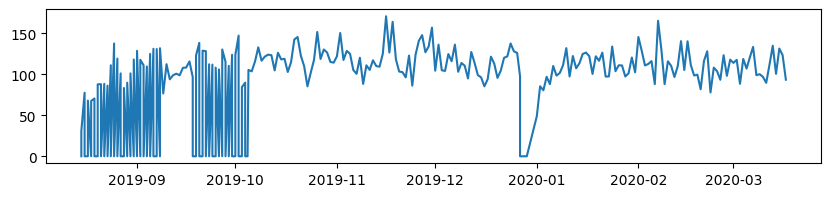

In [186]:
temp = flair.df_pump.loc[(flair.df_pump.PtID == 14)].dropna(subset=['TDD'])
plt.figure(figsize=(10, 2))
plt.plot(temp.DateTime, temp.TDD);

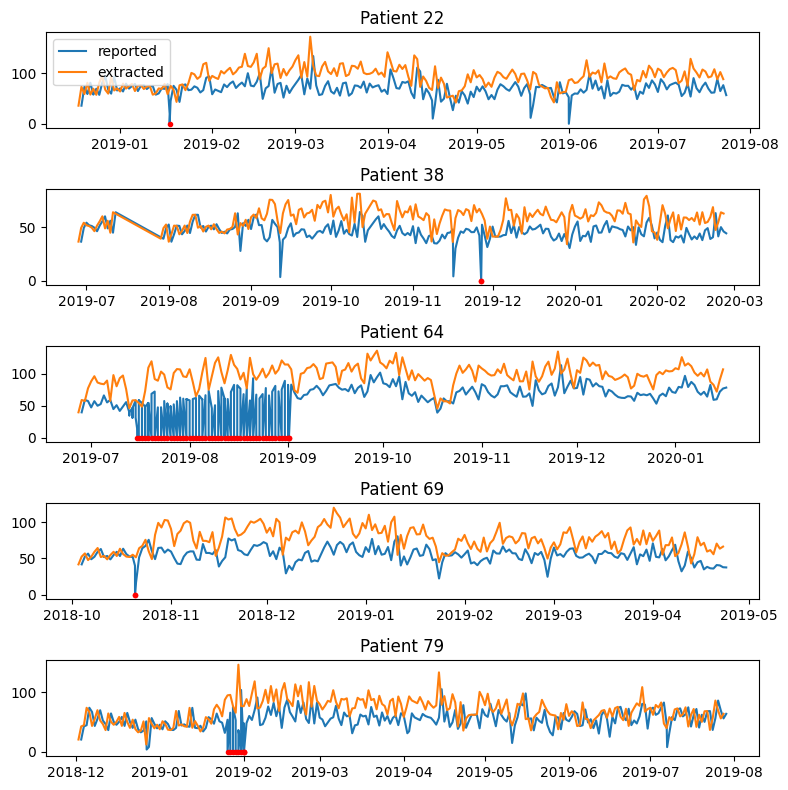

In [226]:
#get affected patients
tdd_zero = TDDs.loc[TDDs.tdd_reported == 0]
patients_with_tdd_zero = tdd_zero.index.get_level_values('patient_id').unique().astype(int)

# Select all patients with TDD zero
fig, axs = plt.subplots(5, 1, figsize=(8, 8))

for i, patient in enumerate(np.random.choice(patients_with_tdd_zero, 5)):
    temp = flair.df_pump.loc[(flair.df_pump.PtID == patient)].dropna(subset=['TDD'])
    bZero = temp.TDD == 0
    axs[i].plot(temp.DateTime, temp.TDD, label='reported')
    axs[i].plot(temp.DateTime[bZero], temp.TDD[bZero], 'r.')

    temp2 = TDDs.loc[str(patient)].reset_index()
    axs[i].plot(temp2.date, temp2.bolus_wo_dups + temp2.basal, label='extracted')

    axs[i].set_title(f"Patient {patient}")

axs[0].legend()
plt.tight_layout()
plt.show()


Let's check if TDDs are potentially reported several times and this causes fluctuations?

In [292]:
# let's check if there are days where tdd is reported multiple times
TDDs.groupby(['patient_id','date']).tdd_reported.count().value_counts()

1    23047
2      925
3       91
4       13
5        6
Name: tdd_reported, dtype: int64

In [293]:
# let's check if there are days where tdd is reported multiple times
tdd_groups = TDDs.groupby(['patient_id','date'])
tdd_group_counts = tdd_groups.tdd_reported.count()
tdd_group_counts_ge2 = tdd_group_counts[tdd_group_counts > 2]
display(tdd_group_counts_ge2.head())

patient_id  date      
104         2019-06-10    5
            2019-06-21    3
111         2019-03-31    3
115         2019-04-14    3
117         2019-04-03    5
Name: tdd_reported, dtype: int64

In [281]:
#let's look at patient 104 on 2019-06-10 for which several TDDs are reported
TDDs.loc['104',datetime(2019,6,10).date()]

bolus      basal  tdd_calculated            DateTime  \
patient_id date                                                               
104        2019-06-10   10.1  13.217167       23.317167 2019-06-10 18:37:00   
           2019-06-10   10.1  13.217167       23.317167 2019-06-10 18:37:00   
           2019-06-10   10.1  13.217167       23.317167 2019-06-10 18:38:30   
           2019-06-10   10.1  13.217167       23.317167 2019-06-10 23:59:59   
           2019-06-10   10.1  13.217167       23.317167 2019-06-10 23:59:59   

                       tdd_reported            datetime  
patient_id date                                          
104        2019-06-10        12.975 2019-06-10 18:37:00  
           2019-06-10        12.970 2019-06-10 18:37:00  
           2019-06-10         0.000 2019-06-10 18:38:30  
           2019-06-10        10.520 2019-06-10 23:59:59  
           2019-06-10        10.525 2019-06-10 23:59:59

In [280]:
#let's look at patient 104 on 2019-06-10 for which several TDDs are reported
x=flair.df_pump.loc[(flair.df_pump.PtID == 104) & (flair.df_pump.DateTime.dt.date == datetime(2019,6,10).date())].dropna(subset=['TDD'])
display(x.dropna(axis=1, how='all'))

,PtID,DataDtTm,BasalRtUnKnown,TDD,DateTime
972850,104,6/10/2019 6:37:00 PM,False,12.975,2019-06-10 18:37:00
4303707,104,6/10/2019 6:37:00 PM,False,12.970,2019-06-10 18:37:00
972841,104,6/10/2019 6:38:30 PM,False,0.000,2019-06-10 18:38:30
4303676,104,6/10/2019 11:59:59 PM,False,10.520,2019-06-10 23:59:59
972816,104,6/10/2019 11:59:59 PM,False,10.525,2019-06-10 23:59:59
